In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvi
import pickle
import os
import scipy
import seaborn as sns
from datetime import datetime
#%env CUDA_VISIBLE_DEVICES=3
import torch
from data_expl_and_baselines.utils import sample_pt_cells_scvi, viz_props

Global seed set to 0


In [2]:
# set up fonts to work with illustrator
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

#remove top and right axis from plots
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# other figure settings for print
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 300

#axes font sizes for print
plt.rcParams.update({'axes.labelsize': 14})

#ticks font size for print
plt.rcParams.update({'xtick.labelsize': 14})
plt.rcParams.update({'ytick.labelsize': 14})

In [3]:
import random

def set_random_seed(seed_value=42):
    """Set random seed for reproducibility."""
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using CUDA
    np.random.seed(seed_value)
    random.seed(seed_value)

# Call the function before creating your Lightning module, data module, or initializing your data loaders
set_random_seed()

In [4]:
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pytorch_lightning as pl

In [5]:
# make GPU visible
os.environ["CUDA_VISIBLE_DEVICES"]="1"
torch.cuda.is_available()

True

# prep MM anndata for scvi

In [6]:
adata = sc.read_h5ad("/localdata/rna_rep_learning/zavidij_etal/cd45_adata.h5ad")

In [7]:
#temporarily convert to more specific cell types
adata.obs.celltype = adata.obs.Tcellsubtype.astype('str').replace('nan',np.NaN).fillna(adata.obs.celltype.astype('str'))

In [8]:
adata.var = adata.var.reset_index().rename(columns={'index':'gene_symbols'})

In [9]:
# quickly get ensembl id's from a different adata
adata_tmp = sc.read_h5ad("/home/rpeyser/GitHub/mm_singlecell/outputs/script5_MOREHVG/cd138_adata_MOREHVG_noIG.h5ad")
adata_tmp.var

gene_ids  n_cells  highly_variable     means  \
RP11-34P13.7  ENSG00000238009       30            False  0.002199   
RP11-34P13.8  ENSG00000239945        3            False  0.000291   
FO538757.3    ENSG00000279928        4            False  0.000039   
FO538757.2    ENSG00000279457     3614            False  0.187373   
AP006222.2    ENSG00000228463     1161            False  0.070361   
...                       ...      ...              ...       ...   
AL354822.1    ENSG00000278384      223             True  0.017343   
AC004556.1    ENSG00000276345     1234            False  0.071058   
AC233755.2    ENSG00000277856     1385             True  0.918682   
AC233755.1    ENSG00000275063     1251             True  0.108932   
AC240274.1    ENSG00000271254      304            False  0.017605   

              dispersions  dispersions_norm          mean       std  
RP11-34P13.7     1.356706          0.481919  9.083620e-12  0.036487  
RP11-34P13.8     1.159064         -0.019813  6.340806e-13  0.013531  
FO538757.3       0.137654         -2.612757 -6.646891e-13  0.004459  
FO538757.2       1.109164         -0.146487  1.060022e-09  0.333483  
AP006222.2       1.133197         -0.085477 -6.055799e-10  0.205510  
...                   ...               ...           ...       ...  
AL354822.1       1.610254          1.125576  6.177821e-11  0.101255  
AC004556.1       1.279541          0.286028 -6.245949e-10  0.202828  
AC233755.2       4.239115          3.957813  7.863021e-10  0.655776  
AC233755.1       1.440178          0.693821 -7.403744e-10  0.259113  
AC240274.1       1.135065         -0.080737 -1.302368e-10  0.102516  

[22273 rows x 8 columns]

In [10]:
tmp_var = pd.merge(adata.var, adata_tmp.var[['gene_ids']], left_on='gene_symbols', right_index=True, how='left')
np.all(tmp_var.index == adata.var.index)

True

In [11]:
adata.var = tmp_var
del tmp_var, adata_tmp

In [12]:
adata.var["ensembl_id"] = adata.var.gene_ids
adata.var.set_index("gene_ids", inplace=True)
adata.obs["n_counts"] = adata.X.sum(axis=1)
adata.obs["joinid"] = list(range(adata.n_obs))
# initialize the batch to be unassigned. This could be any dummy value.
adata.obs["batch"] = "unassigned"


In [13]:
#remove NA genes
adata = adata[:,~adata.var.ensembl_id.isna()].copy()

# load scVI model that was downloaded from CellXGene

In [14]:
#load trained scvi model
model_filename = "/data/rna_rep_learning/cellxgene_census_20240701/scvi_model"
scvi.model.SCVI.prepare_query_anndata(adata, model_filename)


INFO     File /data/rna_rep_learning/cellxgene_census_20240701/scvi_model/model.pt already downloaded              


/opt/conda/rpeyser/envs/scset_latest/lib/python3.12/site-packages/scvi/model/base/_utils.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, 

INFO     Found 43.45% reference vars in query data.                                                                


/opt/conda/rpeyser/envs/scset_latest/lib/python3.12/site-packages/scvi/model/base/_archesmixin.py:202: UserWarning: Query data contains less than 80% of reference var names. This may result in poor performance.
  warnings.warn(
/opt/conda/rpeyser/envs/scset_latest/lib/python3.12/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [15]:
# forward pass query data through the model
vae_q = scvi.model.SCVI.load_query_data(
    adata,
    model_filename,
)

# This allows for a simple forward pass
vae_q.is_trained = True
latent = vae_q.get_latent_representation()
adata.obsm["scvi"] = latent

# filter out missing features
adata = adata[:, adata.var["gene_symbols"].notnull().values].copy()
adata.var.set_index("gene_symbols", inplace=True)

INFO     File /data/rna_rep_learning/cellxgene_census_20240701/scvi_model/model.pt already downloaded              


/opt/conda/rpeyser/envs/scset_latest/lib/python3.12/site-packages/scvi/model/base/_utils.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, 

# quickly do some data exploration to make sure cell types look reasonable in latent space

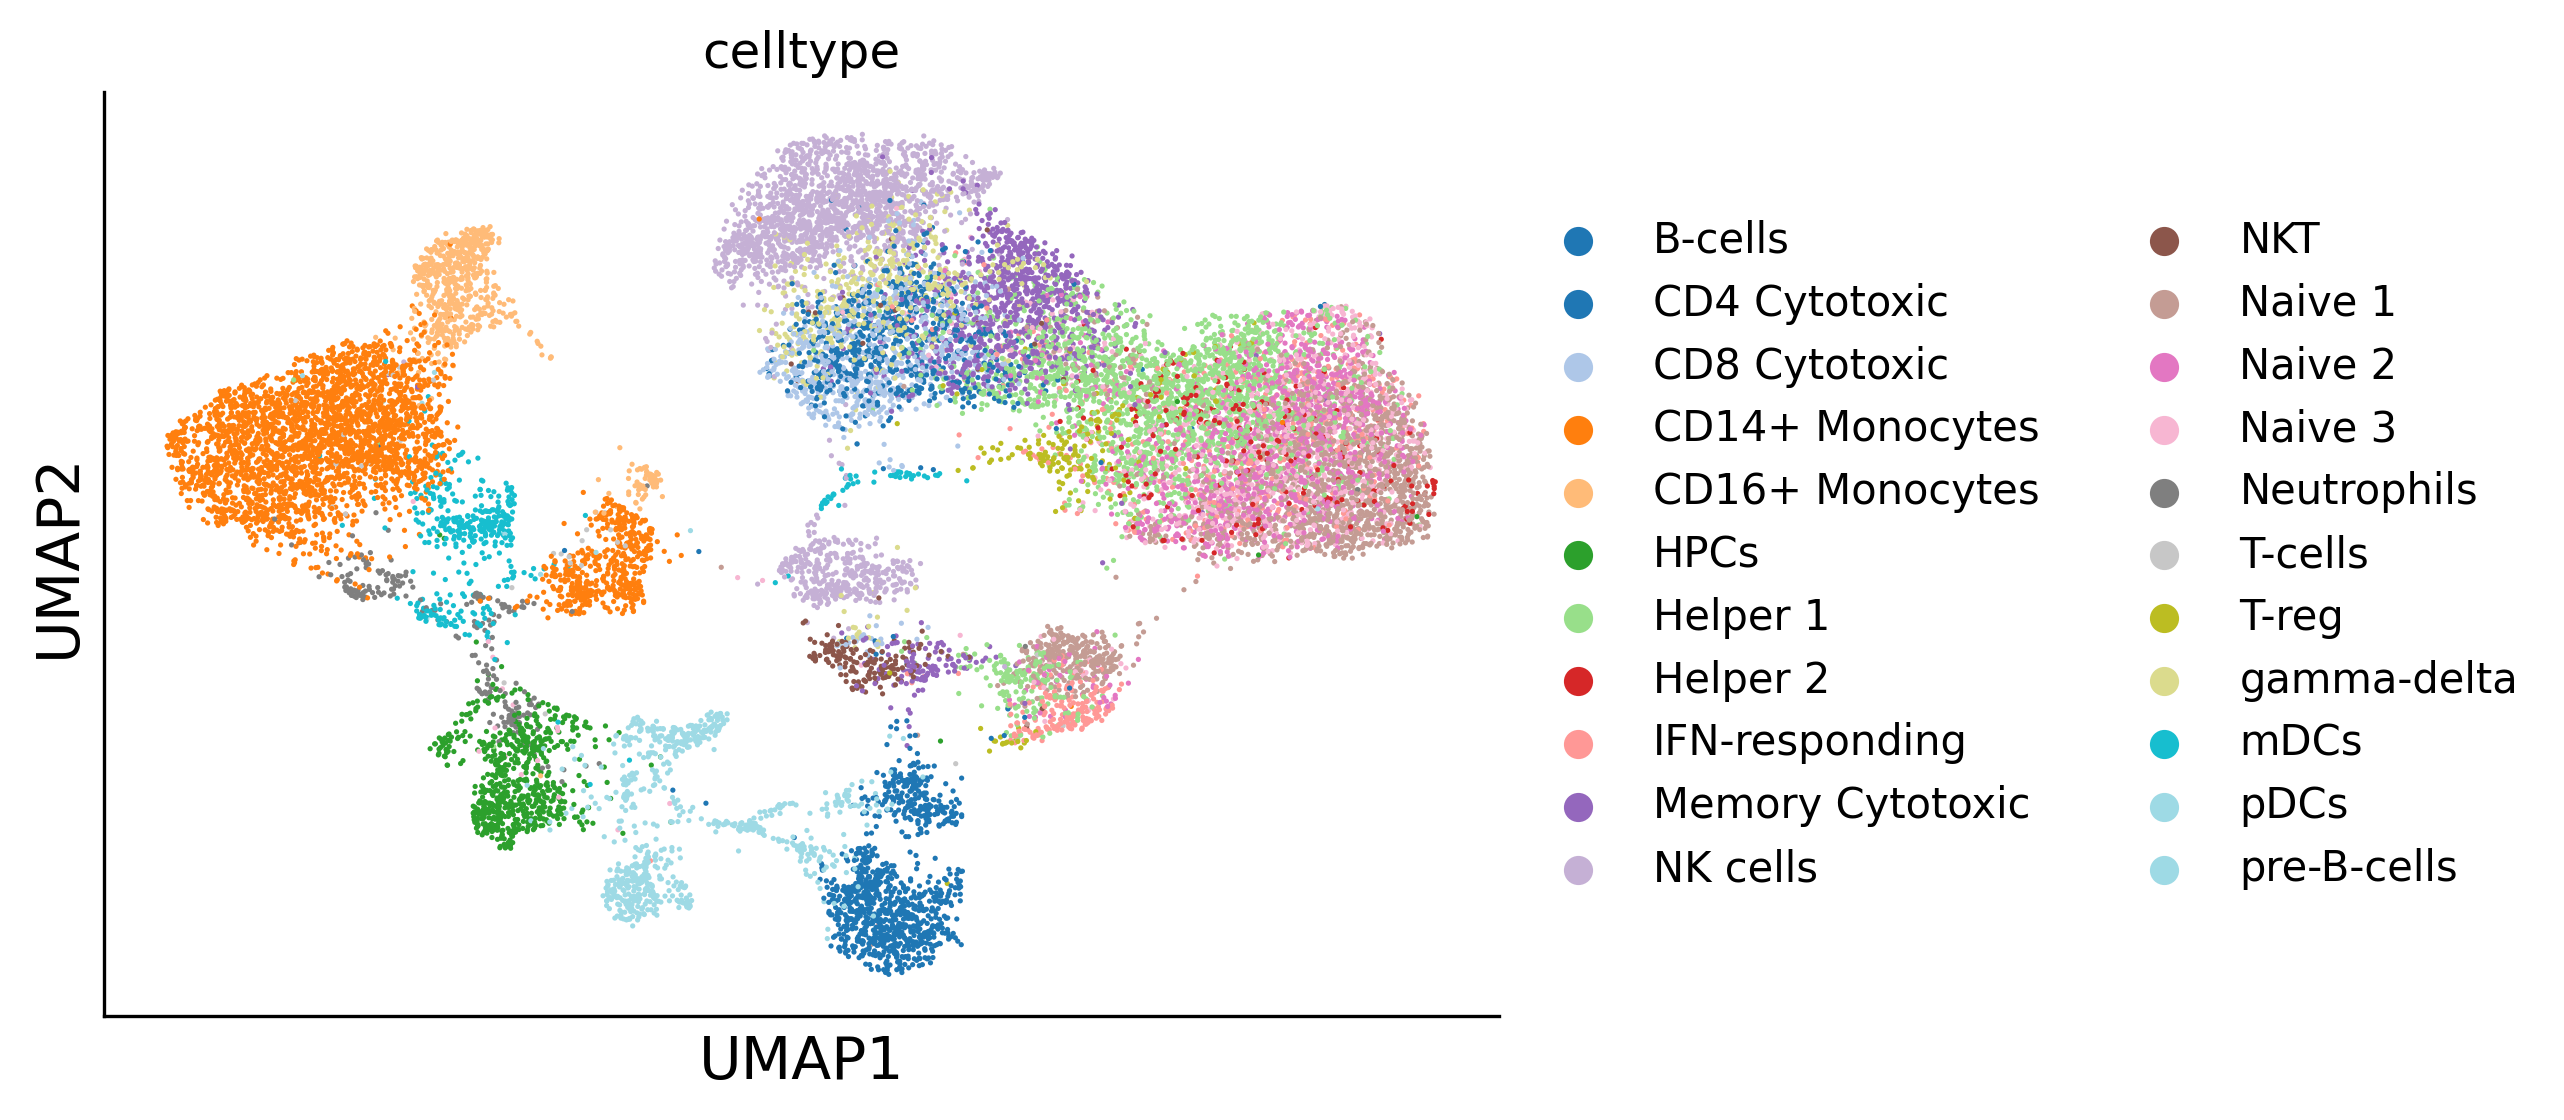

In [16]:
sc.pp.neighbors(adata, n_neighbors=15, use_rep="scvi")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["celltype"], palette="tab20")

In [17]:
# add categorical Naive T cell celltype
adata.obs.celltype = adata.obs.celltype.astype('str')
adata.obs.loc[adata.obs.celltype.isin(['Naive 1', 'Naive 2', 'Naive 3']),"celltype"] = "Naive T cell"

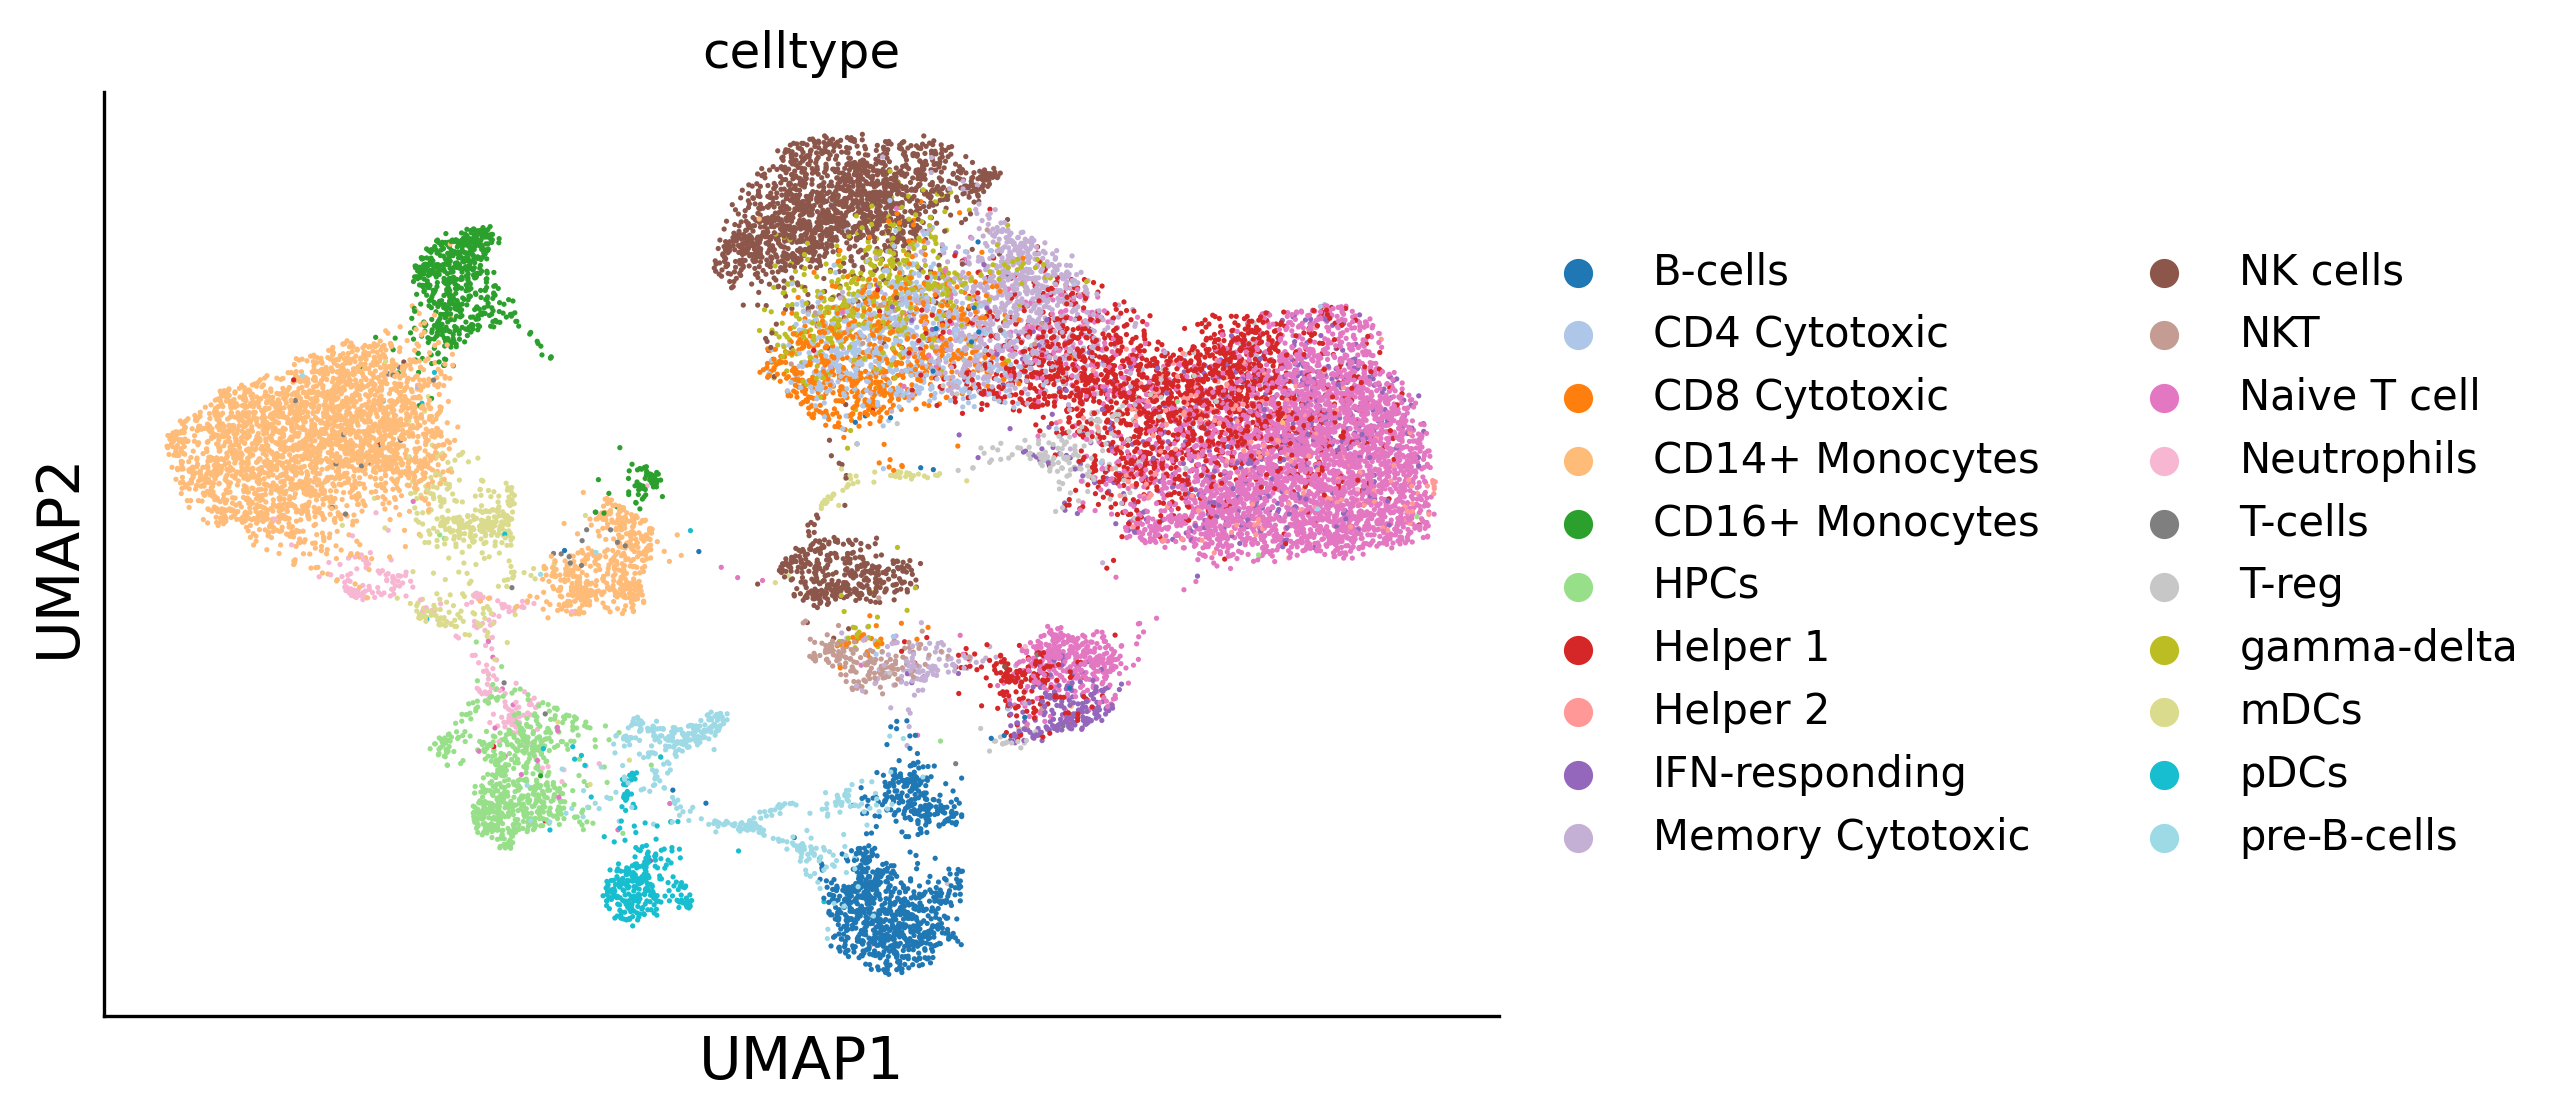

In [18]:
sc.pl.umap(adata, color=["celltype"], palette="tab20")

In [19]:
adata.obs.celltype.value_counts()

celltype
Naive T cell        3818
CD14+ Monocytes     3101
Helper 1            2101
NK cells            2100
Memory Cytotoxic    1007
B-cells             1005
IFN-responding       774
CD8 Cytotoxic        762
HPCs                 656
CD16+ Monocytes      631
CD4 Cytotoxic        629
gamma-delta          458
mDCs                 420
pre-B-cells          420
pDCs                 318
Neutrophils          235
Helper 2             196
T-reg                192
NKT                  175
T-cells               29
Name: count, dtype: int64

# create synthetic data for proportions experiment

In [20]:
# set up stats for 3 groups of patients

cell_types = ["NK cells", "Helper 1", "CD8 Cytotoxic", "CD14+ Monocytes"] #["NK cells", "Helper 1", "B-cells", "CD14+ Monocytes"]  "Naive T cell"
strengths_1 = [0.15, 0.55, 0.15, 0.15]
strengths_2 = [0.15, 0.15, 0.15, 0.55]
strengths_3 = [0.15, 0.15, 0.55, 0.15]
"""
dir_strength = 50

cell_type_dirichlet_concentrations_1=dict(zip(cell_types, [i*dir_strength for i in strengths_1]))
cell_type_dirichlet_concentrations_2=dict(zip(cell_types, [i*dir_strength for i in strengths_2]))
cell_type_dirichlet_concentrations_3=dict(zip(cell_types, [i*dir_strength for i in strengths_3]))
"""


'\ndir_strength = 50\n\ncell_type_dirichlet_concentrations_1=dict(zip(cell_types, [i*dir_strength for i in strengths_1]))\ncell_type_dirichlet_concentrations_2=dict(zip(cell_types, [i*dir_strength for i in strengths_2]))\ncell_type_dirichlet_concentrations_3=dict(zip(cell_types, [i*dir_strength for i in strengths_3]))\n'

In [21]:
print(len(adata.obs[adata.obs.celltype.isin(cell_types)]))
print(len(adata.obs[adata.obs.celltype.isin(cell_types)].patient.unique()))

8064
32


In [22]:
# sample cells for each patient
def get_cell_type_counts(cell_type_dirichlet_concentrations, total_cells):
    sample_cell_type_probs = scipy.stats.dirichlet.rvs([cell_type_dirichlet_concentrations[c] for c in cell_types]).squeeze() #ensures cell_type_concs is indexed in same order as cell_types 
    cell_type_counts = dict(zip(cell_types, scipy.stats.multinomial.rvs(total_cells, sample_cell_type_probs)))

    ## get rid of cell types with zero counts
    cell_type_counts = dict([(c, cell_type_counts[c]) for c in cell_type_counts.keys() if cell_type_counts[c]!=0]) 

    return cell_type_counts

def sample_idxs_pp(cell_type_counts, obs):
    celltype_inds = dict([(c, np.arange(len(obs))[obs.celltype==c]) for c in cell_type_counts.keys()])

    #sample
    chosen_inds = dict([(c, np.random.choice(celltype_inds[c], size = cell_type_counts[c])) for c in cell_type_counts.keys()])
    chosen_inds = np.concatenate(list(chosen_inds.values()))

    return chosen_inds

#get_cell_type_counts
total_cells_pp = 200
cell_type_counts1 = dict(zip(cell_types, [int(i*total_cells_pp) for i in strengths_1]))
cell_type_counts2 = dict(zip(cell_types, [int(i*total_cells_pp) for i in strengths_2]))
cell_type_counts3 = dict(zip(cell_types, [int(i*total_cells_pp) for i in strengths_3]))

sampled_idx = []
synthetic_pt_ids = []
synthetic_group = []
for i in range(4):
    sampled_idx += list(sample_idxs_pp(cell_type_counts1, adata.obs))
    synthetic_pt_ids += list(np.repeat(i, total_cells_pp))
    synthetic_group += list(np.repeat("Helper T dominant", total_cells_pp)) # CD4 dominant #Naive

for i in range(4):
    sampled_idx += list(sample_idxs_pp(cell_type_counts2, adata.obs))
    synthetic_pt_ids += list(np.repeat(i+4, total_cells_pp))
    synthetic_group += list(np.repeat("Monocytes dominant", total_cells_pp))

for i in range(4):
    sampled_idx += list(sample_idxs_pp(cell_type_counts3, adata.obs))
    synthetic_pt_ids += list(np.repeat(i+8, total_cells_pp))
    synthetic_group += list(np.repeat("CD8+ T dominant", total_cells_pp))


In [23]:
synthetic_adata = adata[sampled_idx].copy()
synthetic_adata.obs['patient'] = synthetic_pt_ids
synthetic_adata.obs['group'] = synthetic_group

synthetic_adata.obs.reset_index(drop=True, inplace=True)

/opt/conda/rpeyser/envs/scset_latest/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/rpeyser/GitHub/scset/data_expl_and_baselines/utils.py:201: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltypecounts = obs_df.groupby(["patient", "celltype"]).count().reset_index().iloc[:,:3]


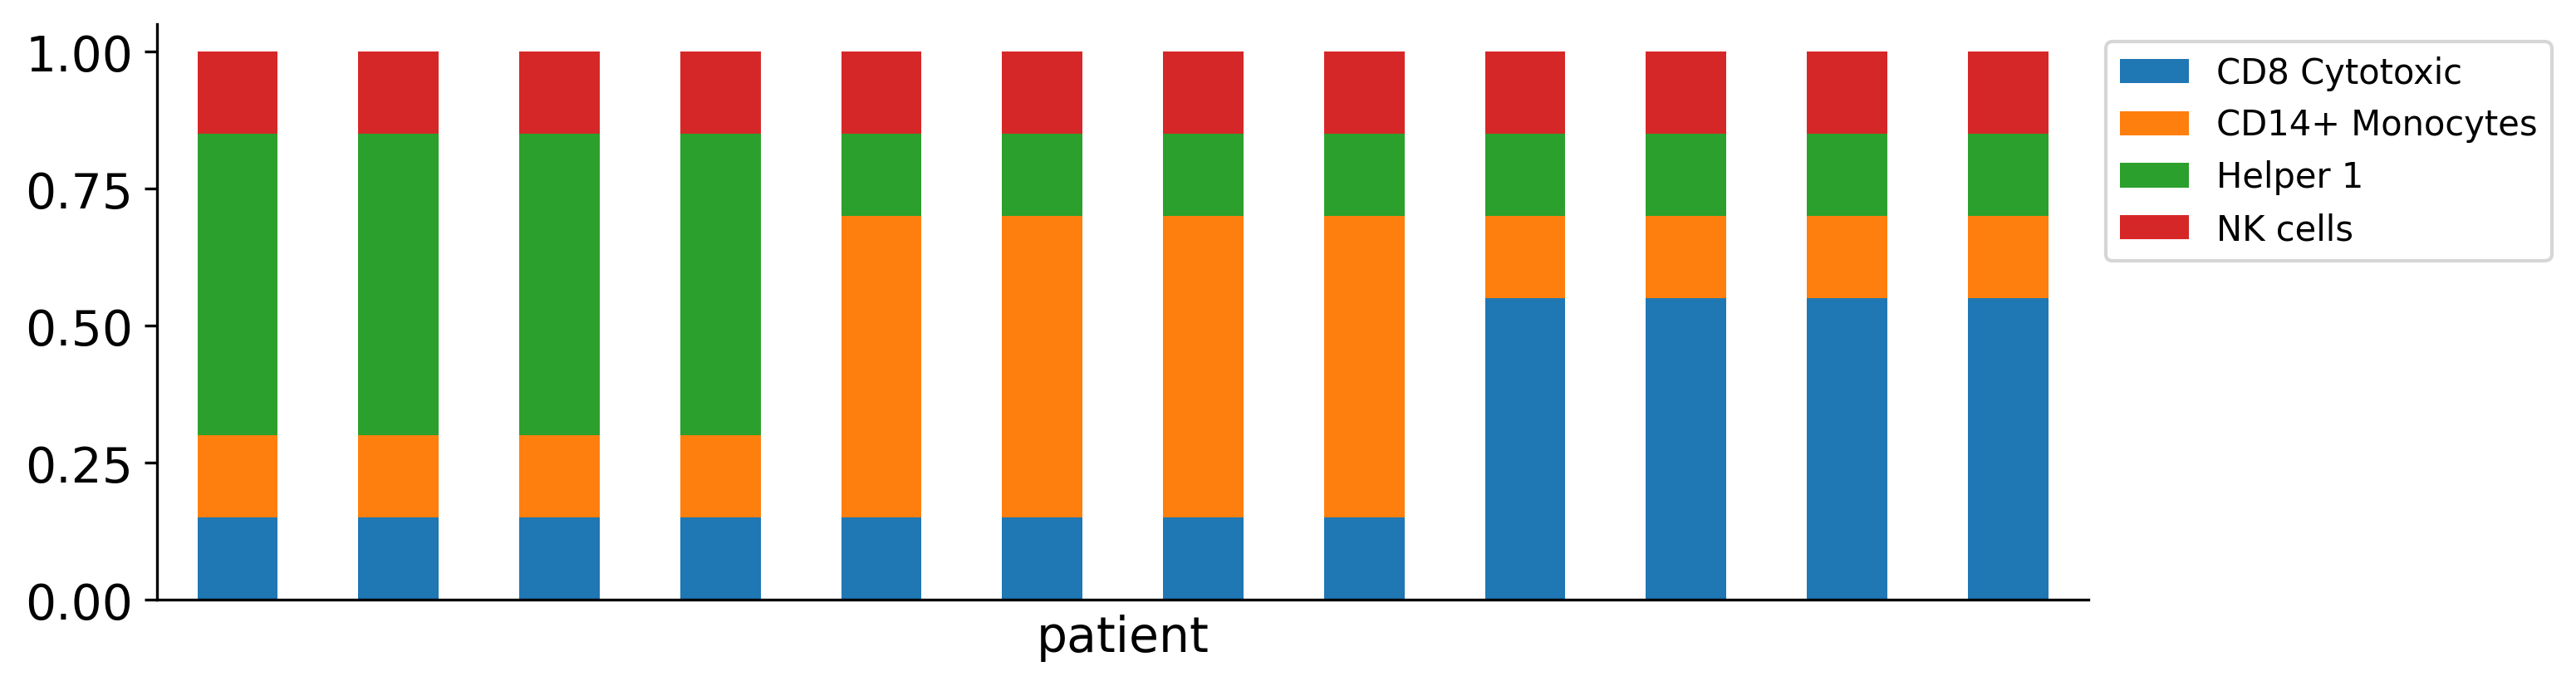

In [24]:
viz_props(synthetic_adata.obs, figsize=[10,3])

# pass this data through scset encoder

In [79]:
import torch
from torch.utils.data import DataLoader
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from datasets.RNASeq import CellBagDataset

import json
from argparse import Namespace

from modules.encoder import build_encoder_model

In [80]:
# get args for cell_transformer diffusion model

with open(os.path.join('/data/rna_rep_learning/scset/outputs/params/incredible-silver-bird-499-cell_transformer-diffusion-hlcatrinary_hvlatents.json'), "rb") as f:
    args_dict = json.load(f)
args = Namespace()
args.__dict__.update(args_dict)

In [81]:
synthetic_adata.obs['dummy_fold'] = 0
synthetic_dataset = CellBagDataset(adata=synthetic_adata, pid_col='patient', target_col='group', fold_col='dummy_fold', adata_layer='scvi', split_ids=[0], max_num_cells=args.max_num_cells, latent_idx_tokeep=args.latent_idx_tokeep)
synthetic_dataloader = DataLoader(dataset=synthetic_dataset, batch_size=12, shuffle=True, pin_memory=True, drop_last=False, num_workers=args.num_workers, collate_fn=synthetic_dataset.collate_fn)

In [82]:
syn_data = next(iter(synthetic_dataloader))

/opt/conda/rpeyser/envs/scset_latest/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/rpeyser/envs/scset_latest/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [83]:
syn_data.keys()

dict_keys(['idx', 'pid', 'set', 'target', 'fold', 'set_mask', 'cardinality'])

In [84]:
np.unique(synthetic_adata.obs['group'], return_inverse=True)

(array(['CD8+ T dominant', 'Helper T dominant', 'Monocytes dominant'],
       dtype=object),
 array([1, 1, 1, ..., 0, 0, 0]))

In [85]:
# load trained encoder
pretrained_ckpt = '/data/rna_rep_learning/scset/outputs/checkpoints/incredible-silver-bird-499-cell_transformer-diffusion-hlcatrinary_hvlatents/pretrained.pt'

encoder = build_encoder_model(args, sample_dim=14)
model_weights = torch.load(pretrained_ckpt, weights_only=True)
encoder.load_state_dict(model_weights['encoder'])
encoder.cuda()
encoder.eval();

In [86]:
patient_emb_wpretraining = encoder(syn_data['set'].cuda(), X_mask=syn_data['set_mask'].cuda())

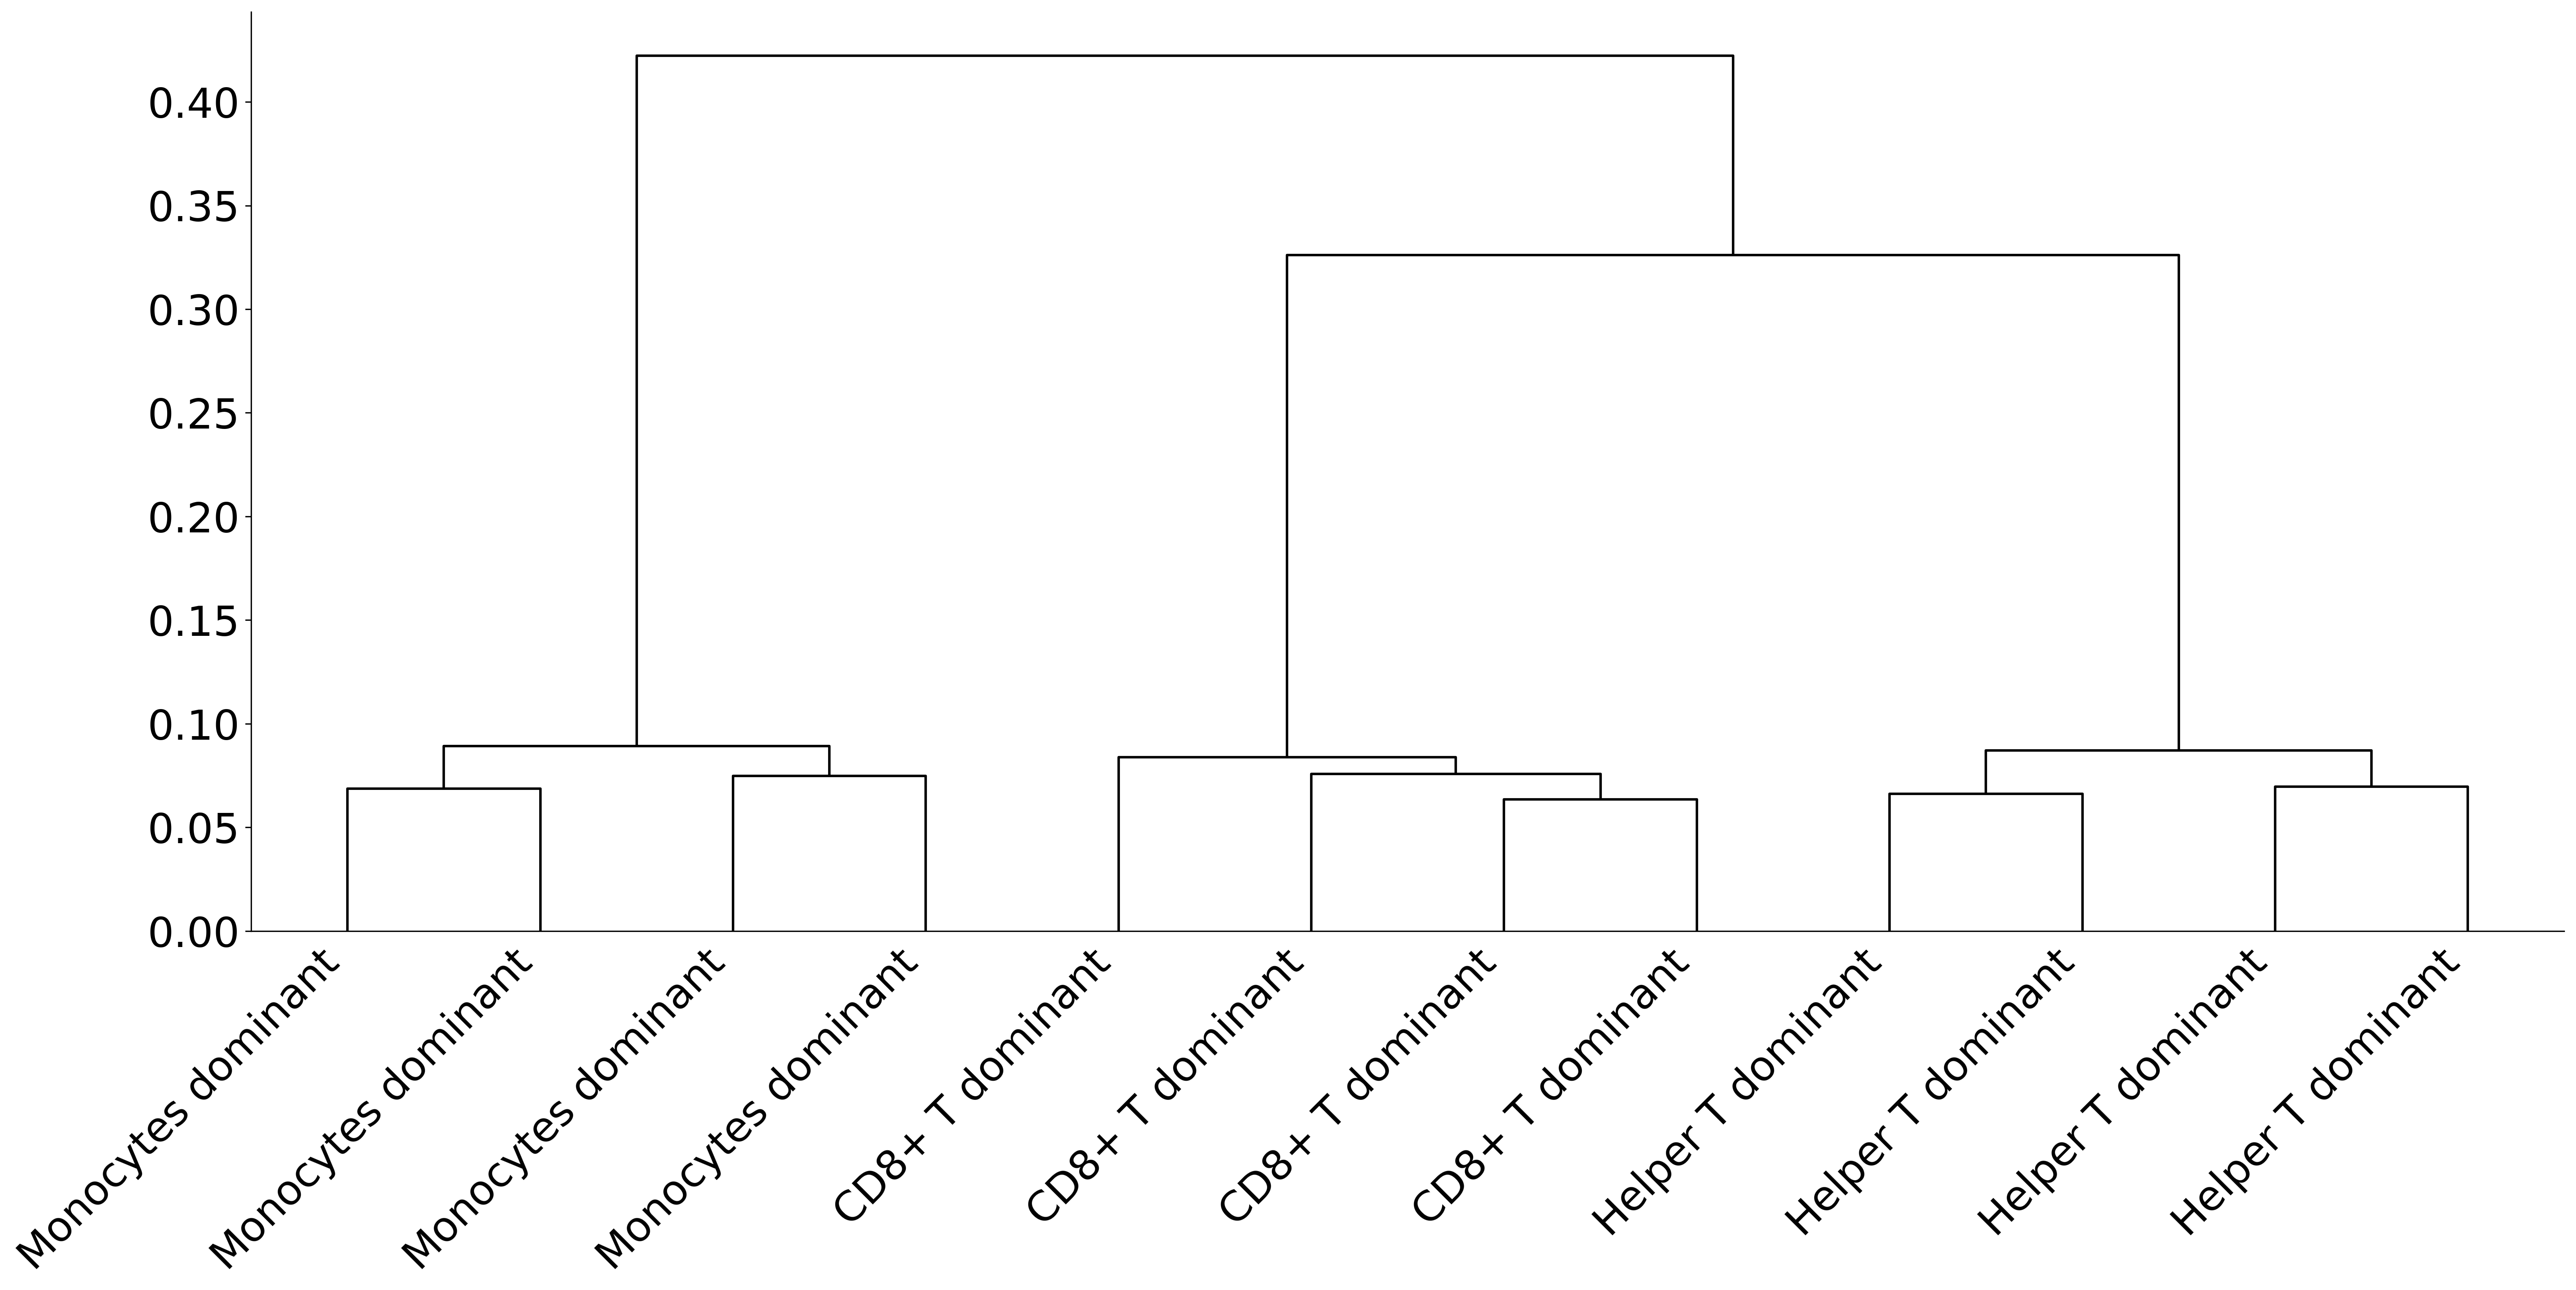

In [89]:
# plot dendrogram of patient embeddings
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist



patient_embs = patient_emb_wpretraining.detach().cpu().numpy()

Z = linkage(patient_embs, 'ward')

# label dendrogram by syn_data['target'] which is ordered same as emb
fig = plt.figure(figsize=(25, 10))
text_labels = list(pd.Series(syn_data['target']).map(dict(zip([0,1,2], np.unique(synthetic_adata.obs['group'], return_inverse=True)[0]))))
dn = dendrogram(Z, labels=text_labels, color_threshold=None, link_color_func=lambda k: 'black')
# 45 degree rotation x labels
plt.xticks(rotation=45, ha='right')
#larger axis labels
plt.tick_params(axis='both', which='major', labelsize=25)

plt.savefig('figures/synthetic_props_dendrogram_scset.pdf', bbox_inches='tight')

In [52]:
Z

array([[ 1.        ,  6.        ,  0.05729797,  2.        ],
       [ 0.        ,  8.        ,  0.062339  ,  2.        ],
       [ 7.        , 12.        ,  0.06497424,  3.        ],
       [ 2.        ,  3.        ,  0.07277116,  2.        ],
       [ 4.        , 15.        ,  0.07905617,  3.        ],
       [ 5.        , 16.        ,  0.08252513,  4.        ],
       [11.        , 14.        ,  0.08377861,  4.        ],
       [ 9.        , 13.        ,  0.08805197,  3.        ],
       [10.        , 19.        ,  0.09307295,  4.        ],
       [17.        , 20.        ,  0.35601999,  8.        ],
       [18.        , 21.        ,  0.44853293, 12.        ]])

In [53]:
#viz patient embeddings on UMAP
reducer = umap.UMAP()
pt_umap = reducer.fit_transform(patient_emb_wpretraining.detach().cpu().numpy())

/opt/conda/rpeyser/envs/scset_latest/lib/python3.12/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [54]:
annots_embeds_w_pretraining = pd.concat([pd.DataFrame({'pid':syn_data['pid'], 'target':text_labels}), pd.DataFrame(pt_umap)], axis=1)

Text(0, 0.5, 'UMAP 2')

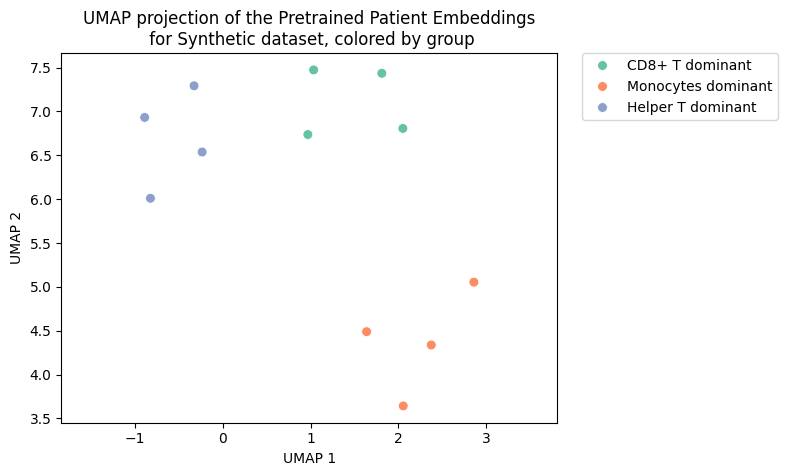

In [55]:
sns.scatterplot(annots_embeds_w_pretraining, x=0, y=1, hue='target', s=50, palette='Set2')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Pretrained Patient Embeddings\n for Synthetic dataset, colored by group', fontsize=12);
#move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=1)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

Text(0, 0.5, 'UMAP 2')

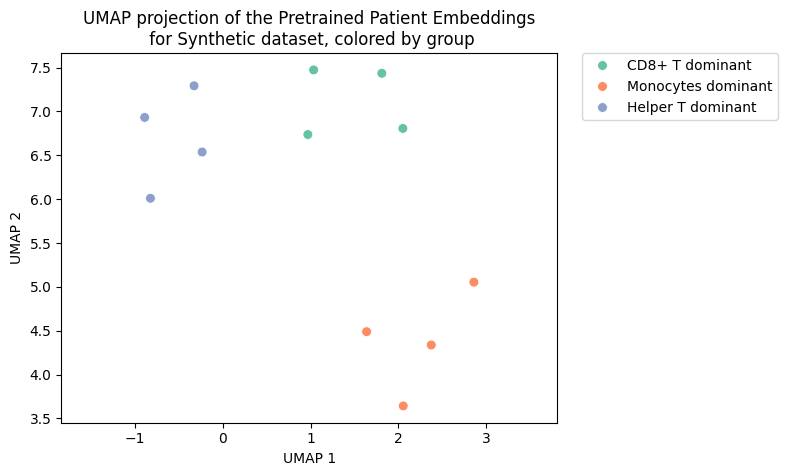

In [56]:
sns.scatterplot(annots_embeds_w_pretraining, x=0, y=1, hue='target', s=50, palette='Set2')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Pretrained Patient Embeddings\n for Synthetic dataset, colored by group', fontsize=12);
#move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=1)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# create dendrogram and UMAP plots for average encoding instead

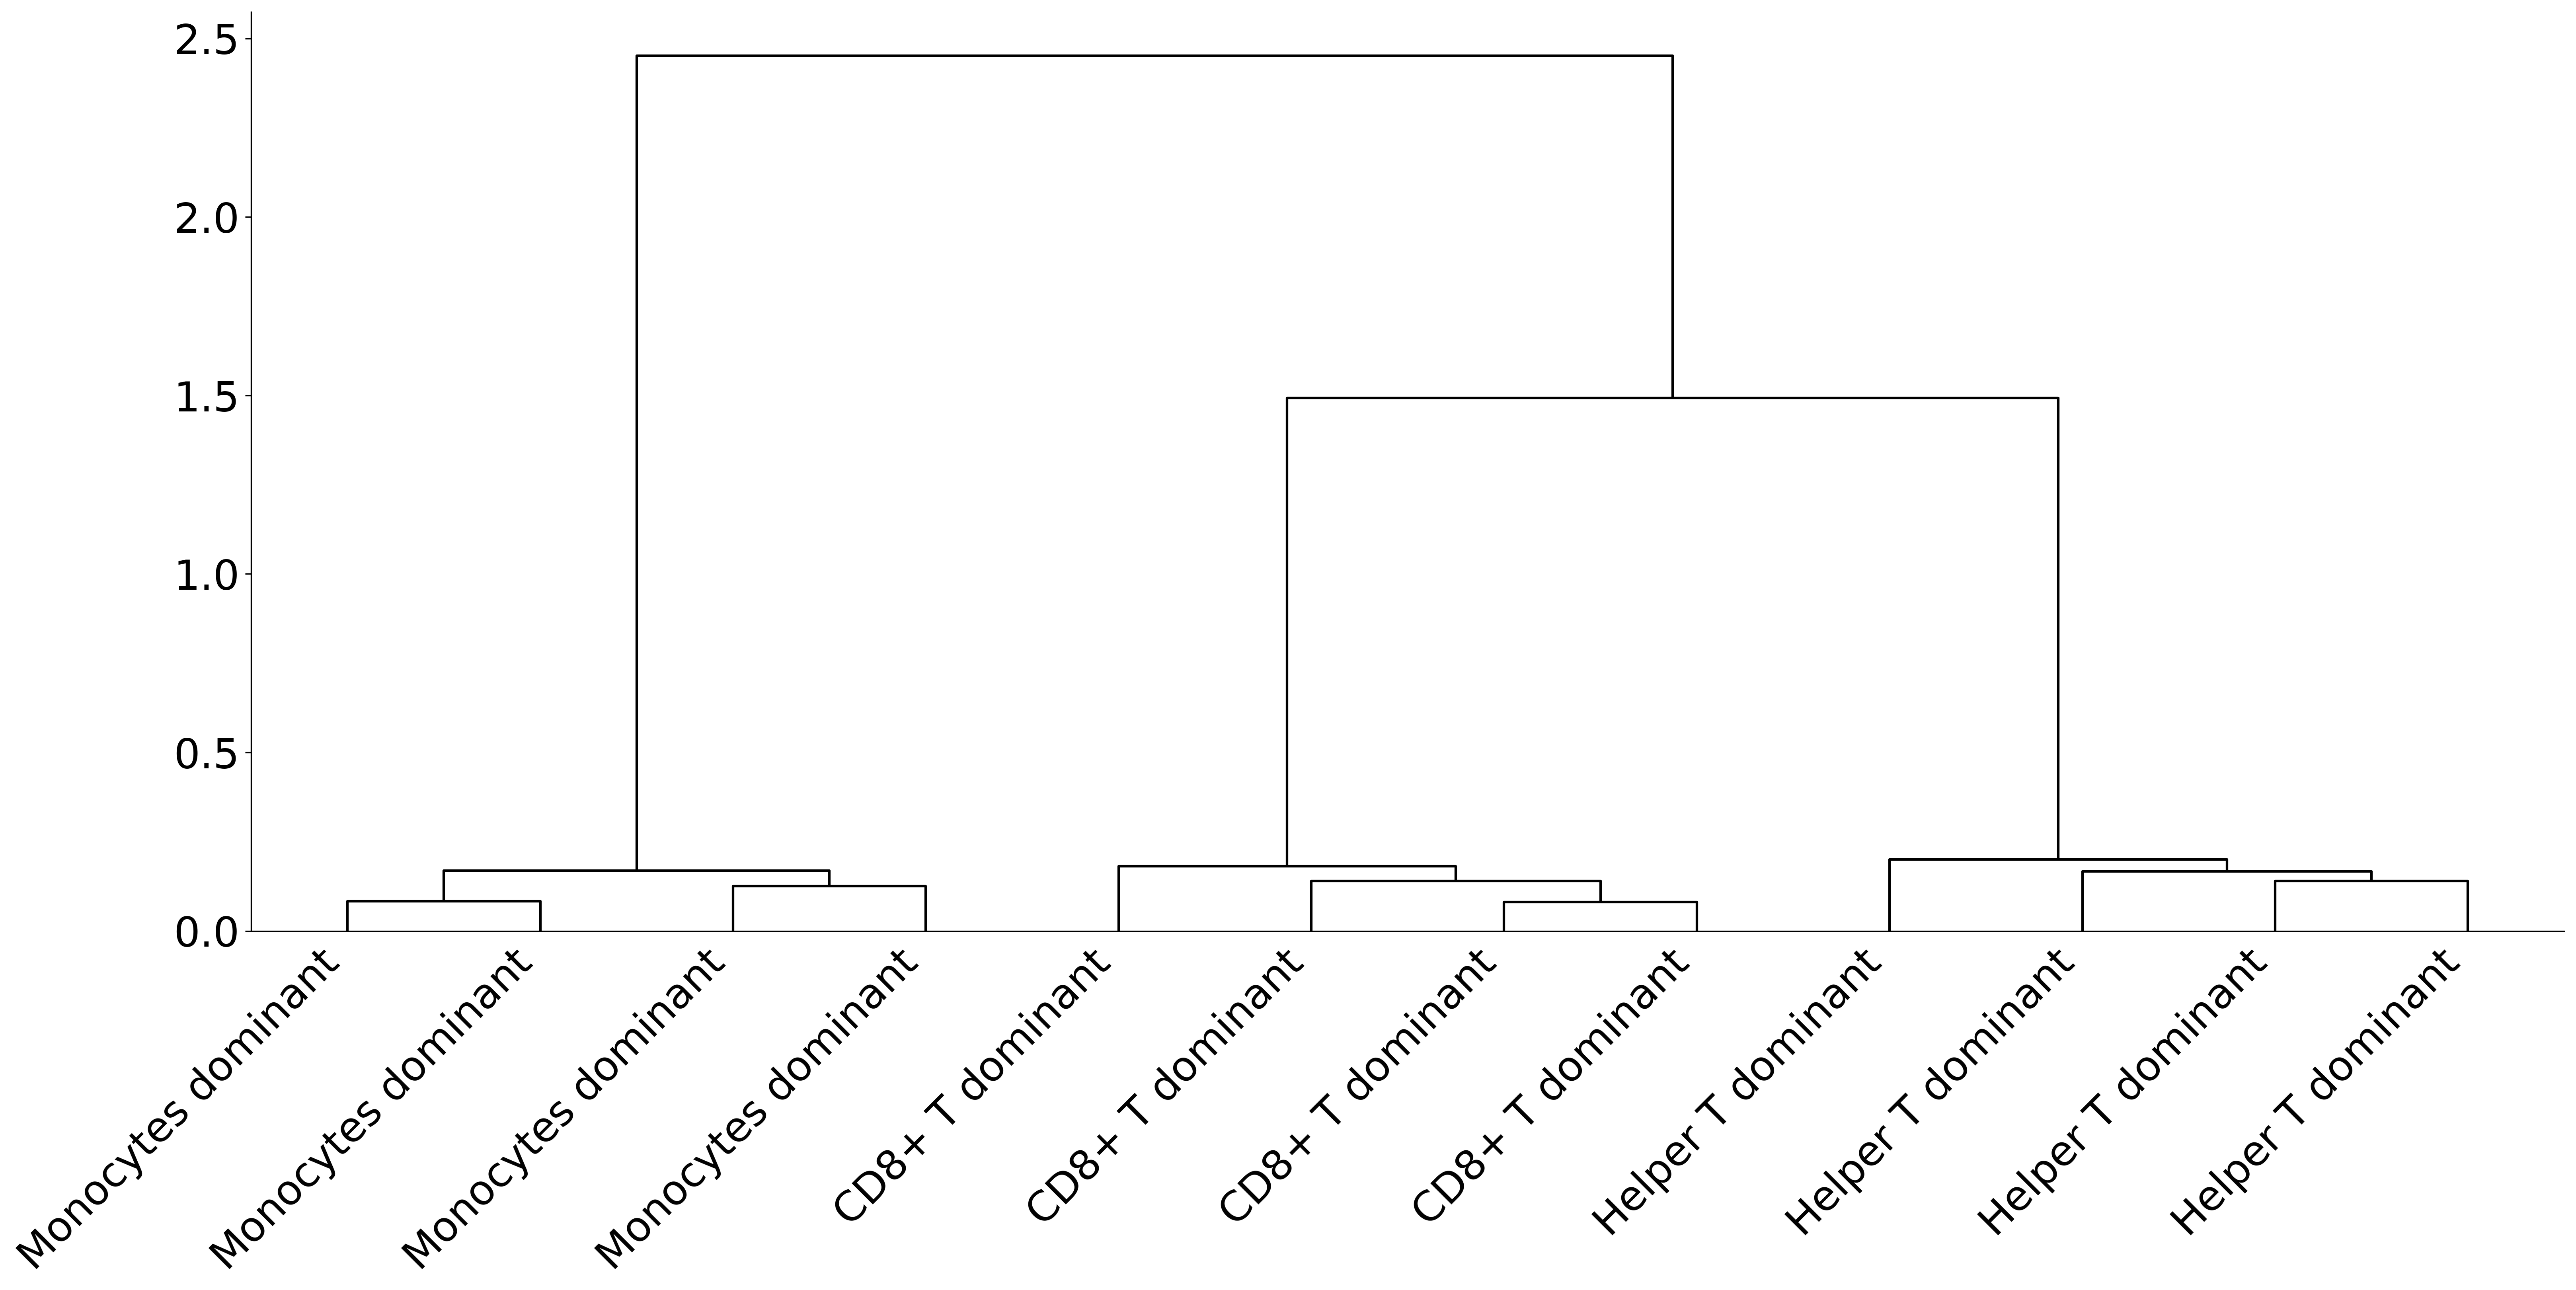

In [90]:
# plot dendrogram of average embeddings

patient_avgs = syn_data['set'].mean(dim=1).detach().numpy()

Z = linkage(patient_avgs, 'ward')

# label dendrogram by syn_data['target'] which is ordered same as emb
fig = plt.figure(figsize=(25, 10))
text_labels = list(pd.Series(syn_data['target']).map(dict(zip([0,1,2], np.unique(synthetic_adata.obs['group'], return_inverse=True)[0]))))
dn = dendrogram(Z, labels=text_labels, color_threshold=None, link_color_func=lambda k: 'black')
# 45 degree rotation x labels
plt.xticks(rotation=45, ha='right')
#larger axis labels
plt.tick_params(axis='both', which='major', labelsize=25)
plt.savefig('figures/synthetic_props_dendrogram_average.pdf', bbox_inches='tight')

# create dendrogram and UMAP plots for K means encoding instead

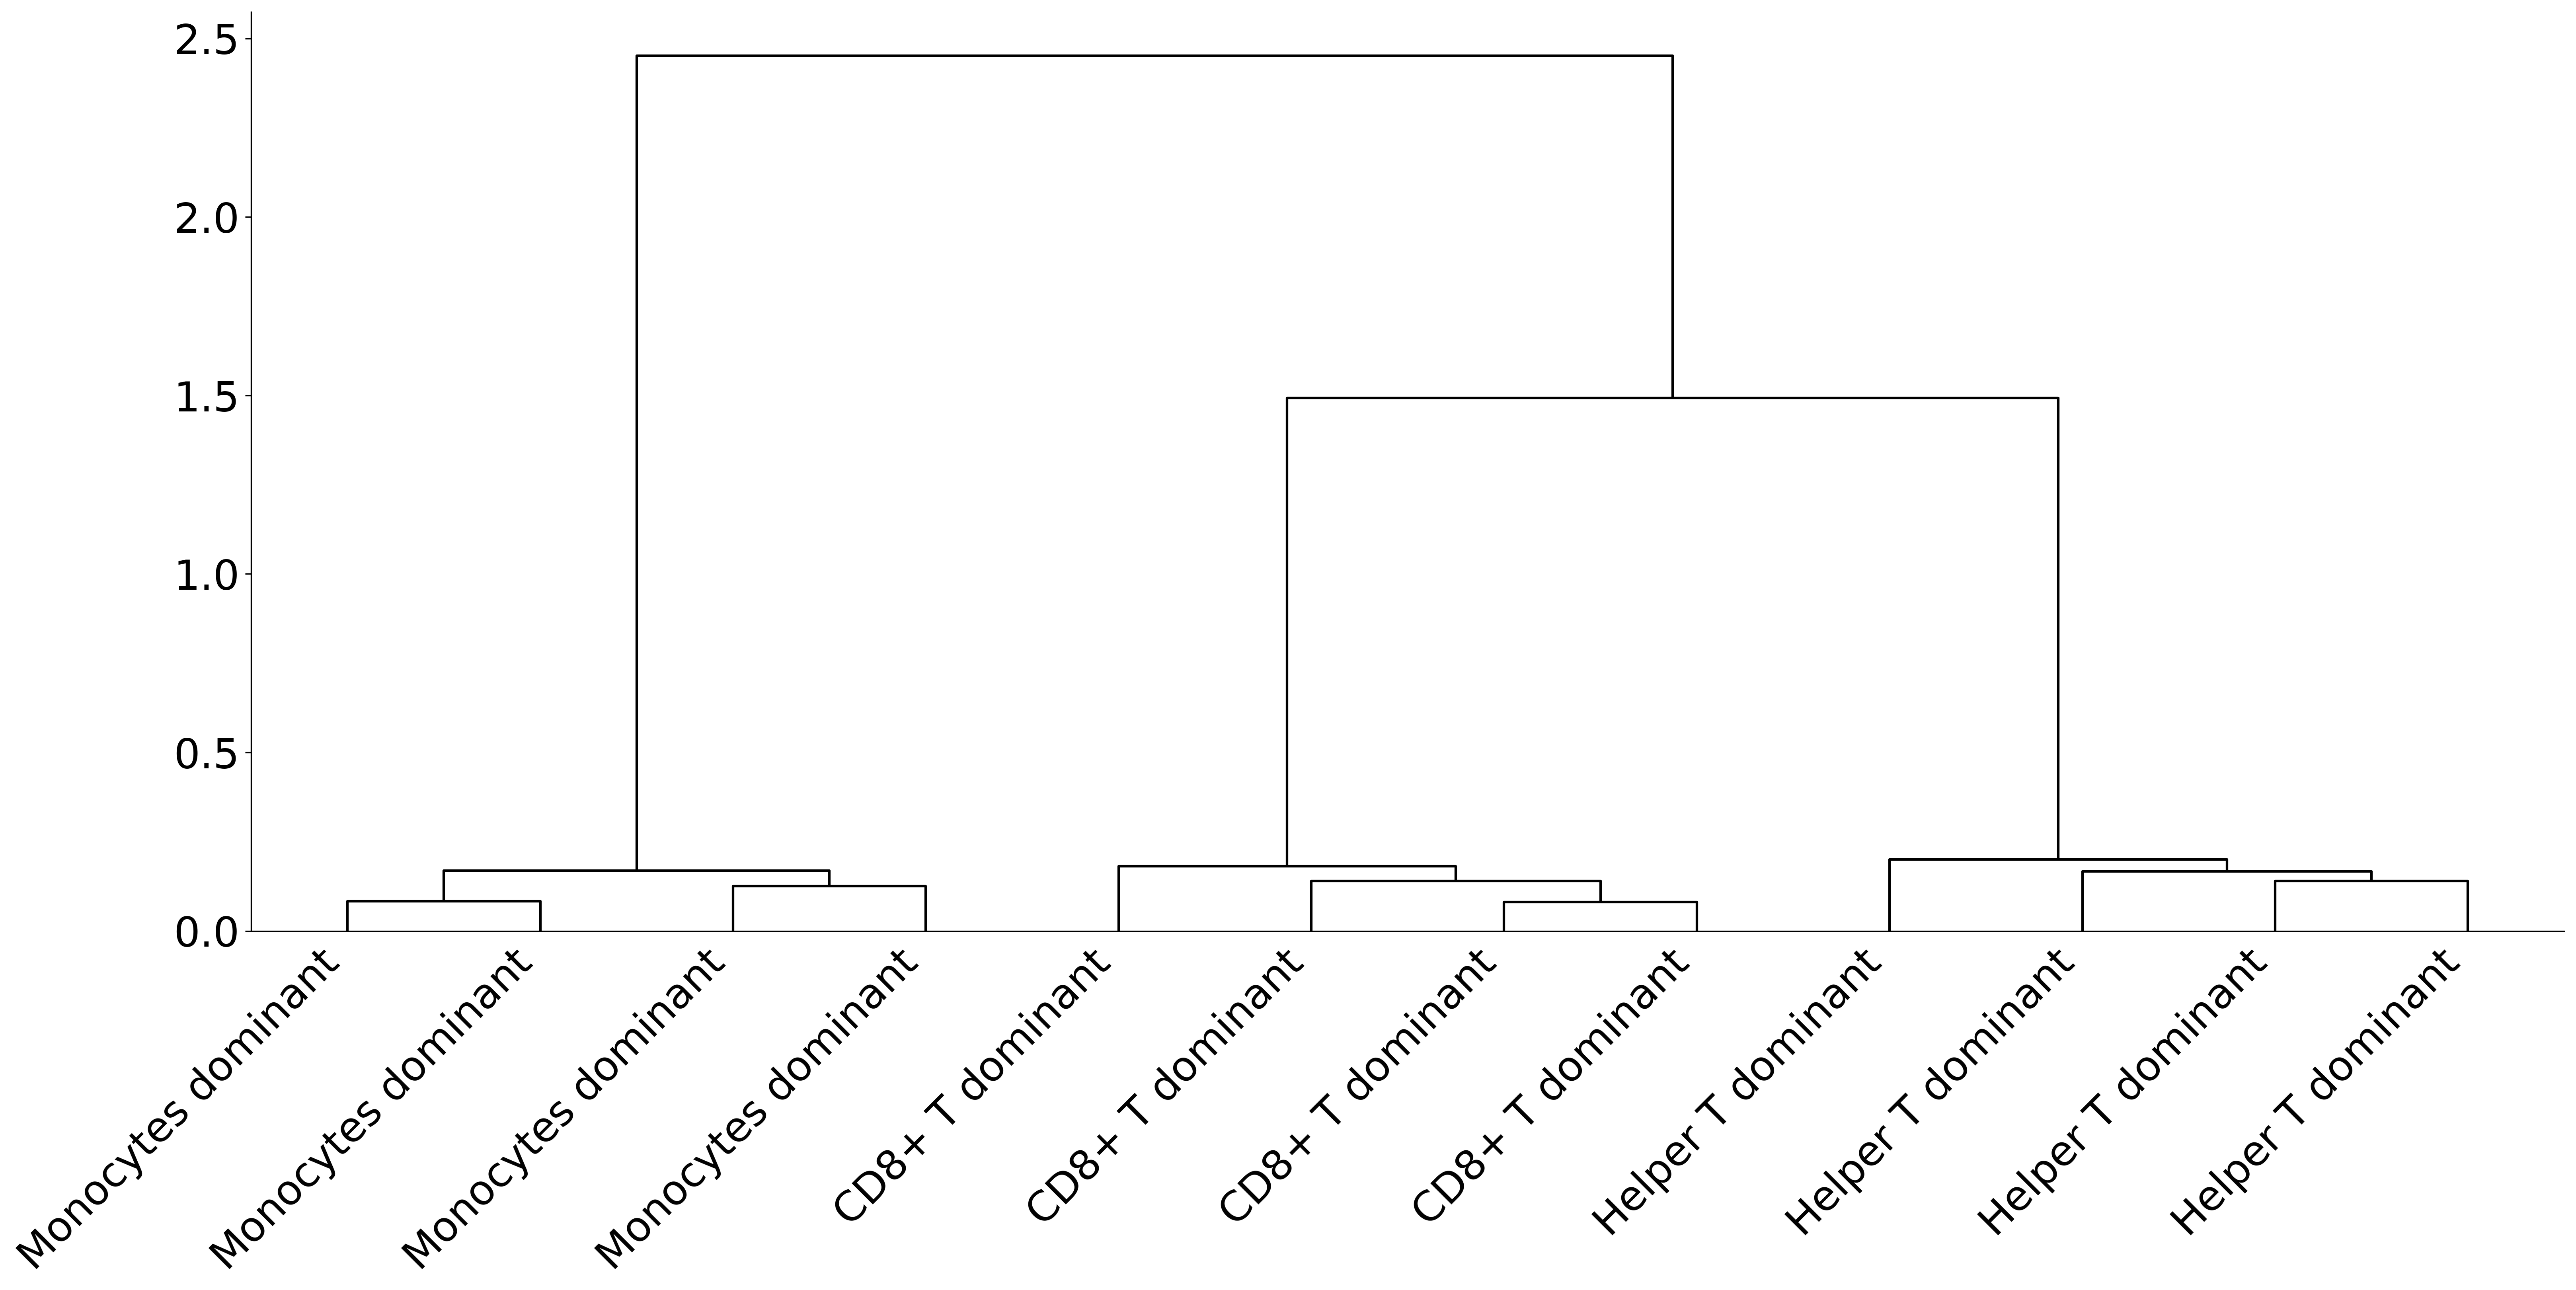

In [ ]:
# plot dendrogram of average embeddings

patient_avgs = syn_data['set'].mean(dim=1).detach().numpy()

Z = linkage(patient_avgs, 'ward')

# label dendrogram by syn_data['target'] which is ordered same as emb
fig = plt.figure(figsize=(25, 10))
text_labels = list(pd.Series(syn_data['target']).map(dict(zip([0,1,2], np.unique(synthetic_adata.obs['group'], return_inverse=True)[0]))))
dn = dendrogram(Z, labels=text_labels, color_threshold=None, link_color_func=lambda k: 'black')
# 45 degree rotation x labels
plt.xticks(rotation=45, ha='right')
#larger axis labels
plt.tick_params(axis='both', which='major', labelsize=25)
plt.savefig('figures/synthetic_props_dendrogram_average.pdf', bbox_inches='tight')

# phenotype experiment

In [91]:
# set up stats for 3 groups of patients

cell_types = ["NK cells", "Helper 1", "CD8 Cytotoxic", "CD14+ Monocytes"] #["NK cells", "Helper 1", "B-cells", "CD14+ Monocytes"]  "Naive T cell"
strengths_1 = [0.25, 0.25, 0.25, 0.25]



In [92]:
total_cells_pp = 200
cell_type_counts1 = dict(zip(cell_types, [int(i*total_cells_pp) for i in strengths_1]))


sampled_idx = []
synthetic_pt_ids = []
synthetic_group = []
for i in range(6):
    sampled_idx += list(sample_idxs_pp(cell_type_counts1, adata.obs))
    synthetic_pt_ids += list(np.repeat(i, total_cells_pp))
    synthetic_group += list(np.repeat("non-perturbed", total_cells_pp))

for i in range(6):
    sampled_idx += list(sample_idxs_pp(cell_type_counts1, adata.obs))
    synthetic_pt_ids += list(np.repeat(i+6, total_cells_pp))
    synthetic_group += list(np.repeat("perturbed", total_cells_pp))



In [93]:
synthetic_adata = adata[sampled_idx].copy()
synthetic_adata.obs['patient'] = synthetic_pt_ids
synthetic_adata.obs['patient'] = synthetic_adata.obs['patient'].astype('str')
synthetic_adata.obs['group'] = synthetic_group

synthetic_adata.obs.reset_index(drop=True, inplace=True)

/opt/conda/rpeyser/envs/scset_latest/lib/python3.12/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### create perturbation

In [94]:
# for patients in perturbed group
# perturb their T cells along 2 latent dimensions, by an average positive shift equaling 25% of mean value of the latent dimension

perturbed_latents = np.array(synthetic_adata.obsm['scvi']).copy()
idx_to_perturb = (synthetic_adata.obs['group'] == 'perturbed') & (synthetic_adata.obs['celltype'] == 'Helper 1')
print(idx_to_perturb.sum())

#print(perturbed_latents.mean(axis=0))  # Before modification

# Modify using the same indexing style, but explicitly reassign
temp = perturbed_latents[idx_to_perturb].copy()  # Copy the selected rows
perturbation_amount = temp[:, [0,1,2,3,4,5]].max(axis=0)
temp[:, [0,1,2,3,4,5]] += perturbation_amount
perturbed_latents[idx_to_perturb] = temp  # Reassign modified rows

# now perturb another cell type in opposite direction
idx_to_perturb = (synthetic_adata.obs['group'] == 'perturbed') & (synthetic_adata.obs['celltype'] == 'CD8 Cytotoxic')
print(idx_to_perturb.sum())

#print(perturbed_latents.mean(axis=0))  # Before modification

# Modify using the same indexing style, but explicitly reassign
temp = perturbed_latents[idx_to_perturb].copy()  # Copy the selected rows
temp[:, [0,1,2,3,4,5]] -= perturbation_amount
perturbed_latents[idx_to_perturb] = temp  # Reassign modified rows


#print(perturbed_latents.mean(axis=0))  # After modification (should now be different)

synthetic_adata.obsm['scvi'] = perturbed_latents

#print(synthetic_adata.obsm['scvi'].mean(axis=0))


300
300


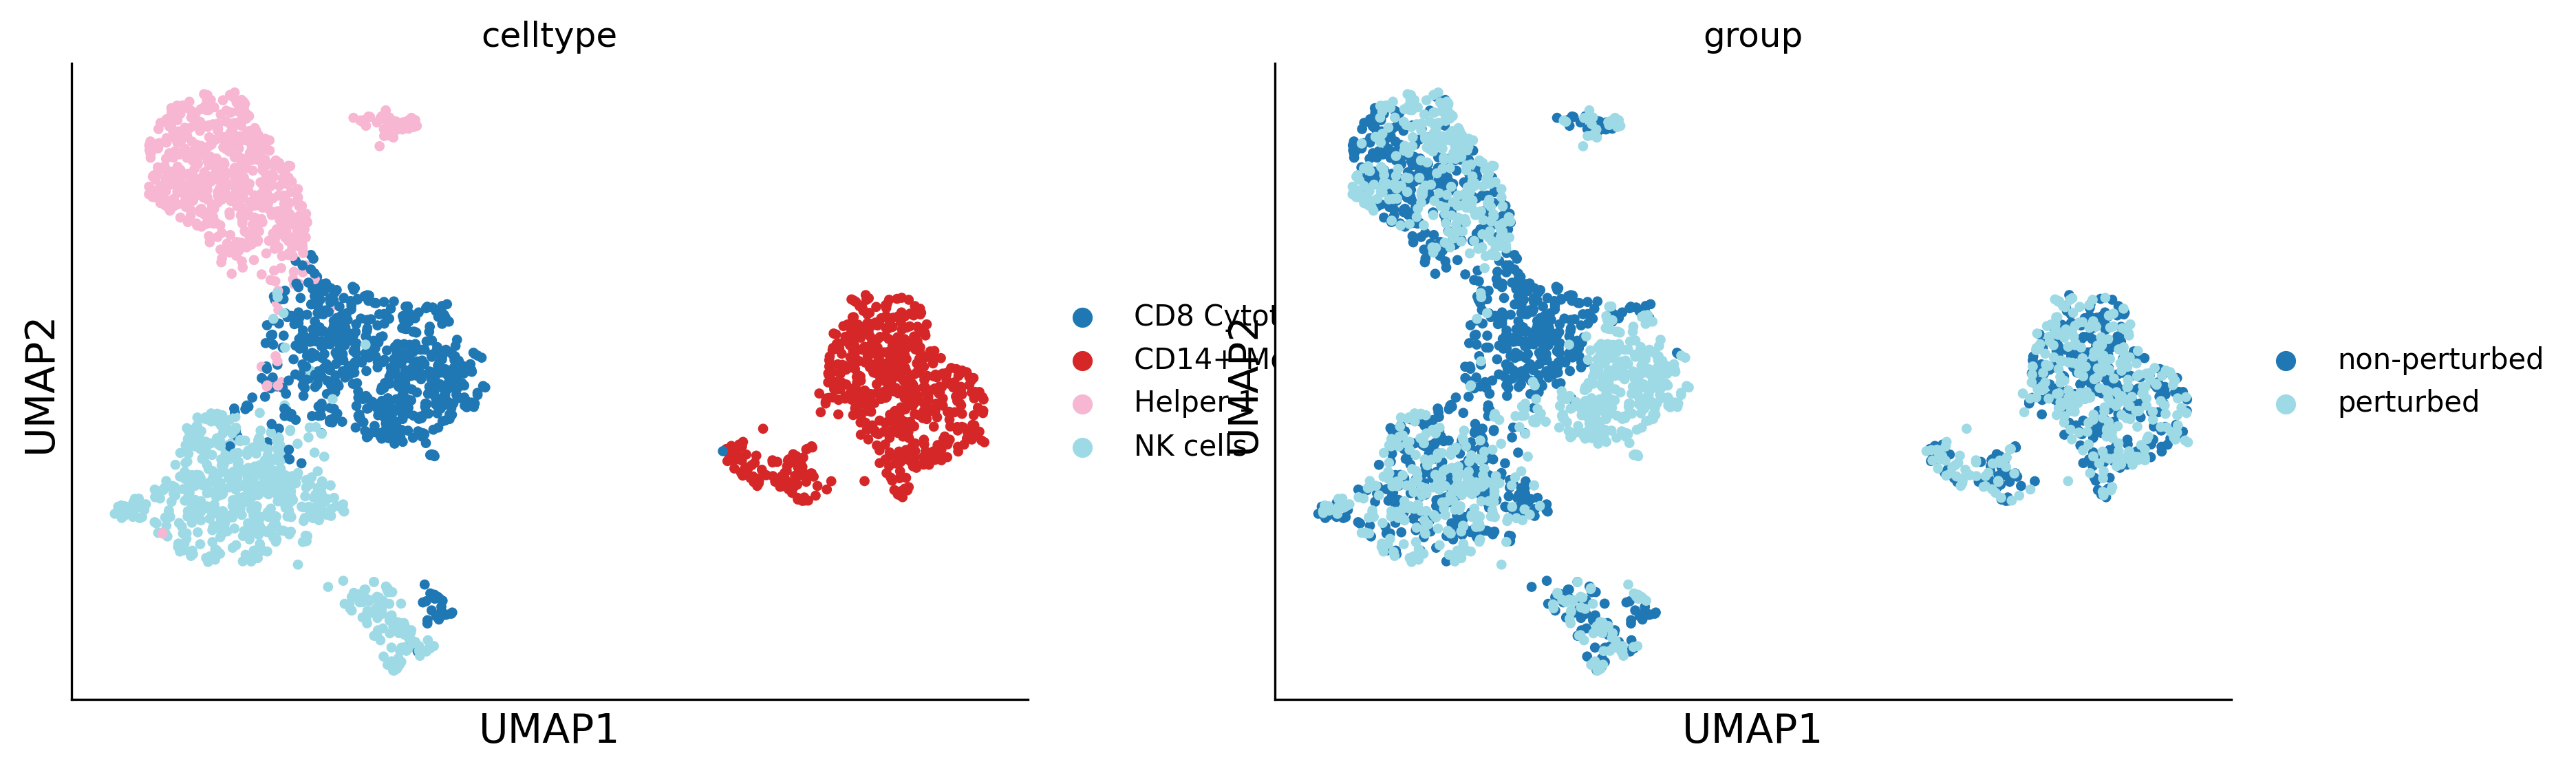

<Figure size 1800x1200 with 0 Axes>

In [95]:
sc.pp.neighbors(synthetic_adata, n_neighbors=15, use_rep="scvi")
sc.tl.umap(synthetic_adata)
sc.pl.umap(synthetic_adata, color=["celltype", 'group'], palette="tab20")
#save fig
plt.savefig('figures/synthetic_pheno_perturbed_cellsumap.pdf', bbox_inches='tight')

# pass this data through scset encoder

In [96]:
# get args for cell_transformer diffusion model

with open(os.path.join('/data/rna_rep_learning/scset/outputs/params/incredible-silver-bird-499-cell_transformer-diffusion-hlcatrinary_hvlatents.json'), "rb") as f:
    args_dict = json.load(f)
args = Namespace()
args.__dict__.update(args_dict)

In [97]:
synthetic_adata.obs['dummy_fold'] = 0
synthetic_dataset = CellBagDataset(adata=synthetic_adata, pid_col='patient', target_col='group', fold_col='dummy_fold', adata_layer='scvi', split_ids=[0], max_num_cells=args.max_num_cells, latent_idx_tokeep=args.latent_idx_tokeep)
synthetic_dataloader = DataLoader(dataset=synthetic_dataset, batch_size=12, shuffle=True, pin_memory=True, drop_last=False, num_workers=args.num_workers, collate_fn=synthetic_dataset.collate_fn)

In [98]:
syn_data = next(iter(synthetic_dataloader))

/opt/conda/rpeyser/envs/scset_latest/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/opt/conda/rpeyser/envs/scset_latest/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [99]:
syn_data.keys()

dict_keys(['idx', 'pid', 'set', 'target', 'fold', 'set_mask', 'cardinality'])

In [100]:
np.unique(synthetic_adata.obs['group'], return_inverse=True)

(array(['non-perturbed', 'perturbed'], dtype=object),
 array([0, 0, 0, ..., 1, 1, 1]))

In [101]:
# load trained encoder
pretrained_ckpt = '/data/rna_rep_learning/scset/outputs/checkpoints/incredible-silver-bird-499-cell_transformer-diffusion-hlcatrinary_hvlatents/pretrained.pt'

encoder = build_encoder_model(args, sample_dim=14)
model_weights = torch.load(pretrained_ckpt, weights_only=True)
encoder.load_state_dict(model_weights['encoder'])
encoder.cuda()
encoder.eval();

In [102]:
patient_emb_wpretraining = encoder(syn_data['set'].cuda(), X_mask=syn_data['set_mask'].cuda())

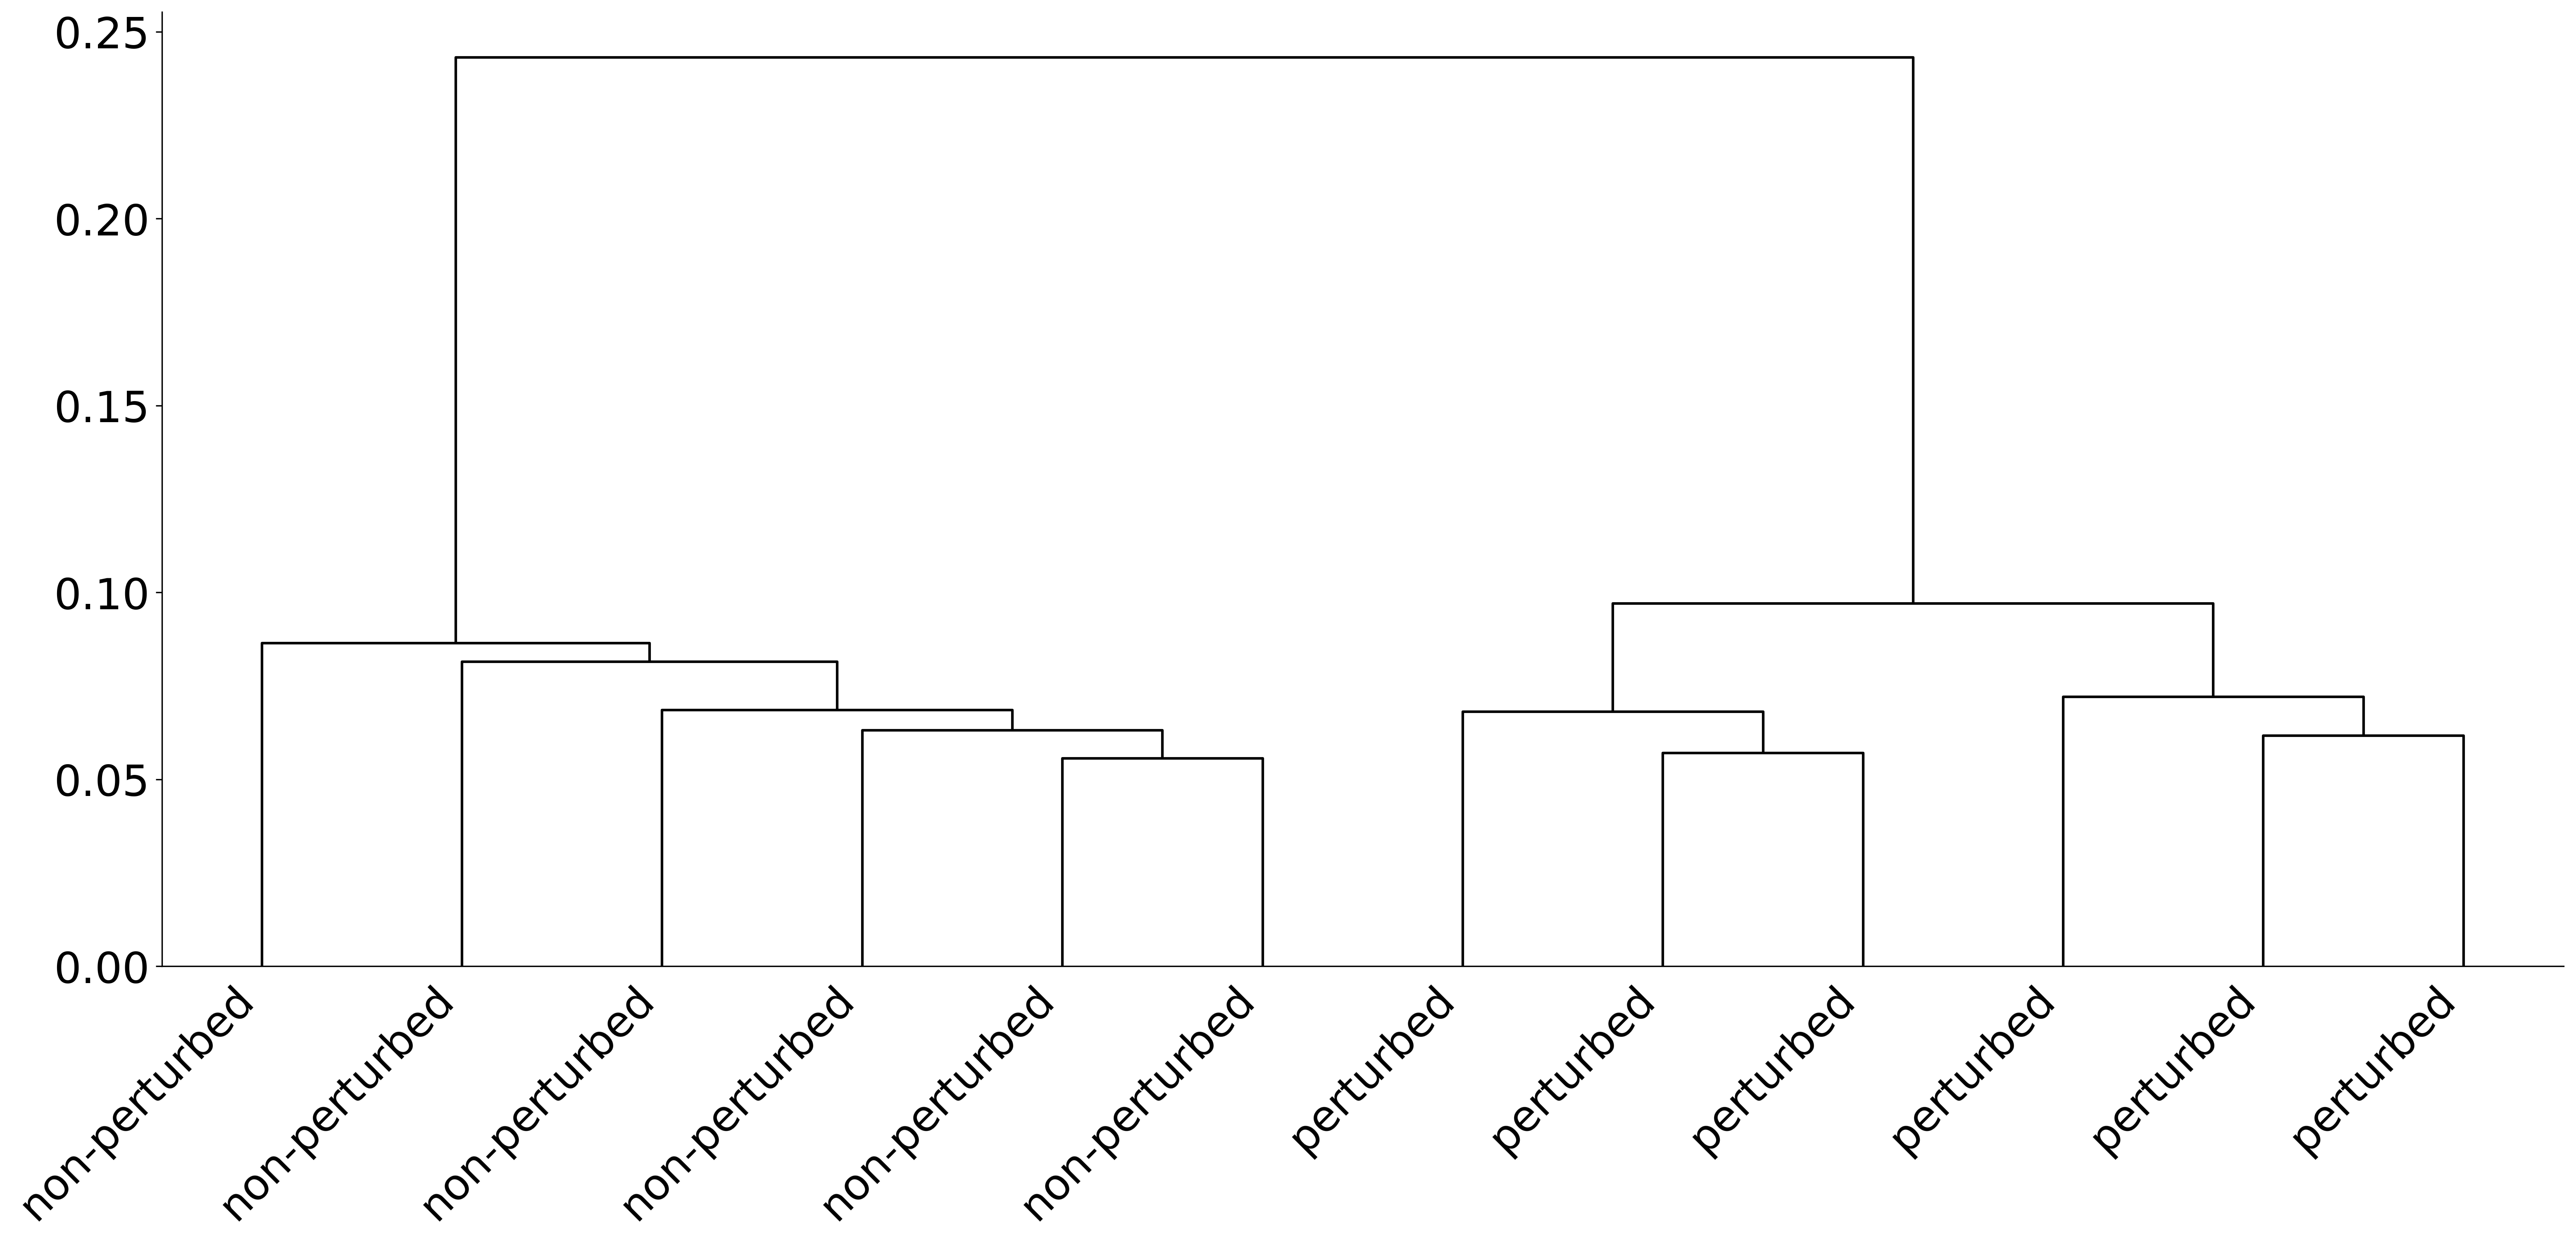

In [103]:
# plot dendrogram of patient embeddings
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

patient_embs = patient_emb_wpretraining.detach().cpu().numpy()

Z = linkage(patient_embs, 'ward')

# label dendrogram by syn_data['target'] which is ordered same as emb
fig = plt.figure(figsize=(25, 10))
text_labels = list(pd.Series(syn_data['target']).map(dict(zip([0,1,2], np.unique(synthetic_adata.obs['group'], return_inverse=True)[0]))))
dn = dendrogram(Z, labels=text_labels, color_threshold=None, link_color_func=lambda k: 'black')
# 45 degree rotation x labels
plt.xticks(rotation=45, ha='right')
#larger axis labels
plt.tick_params(axis='both', which='major', labelsize=25)
plt.savefig('figures/synthetic_pheno_dendrogram_scset.pdf', bbox_inches='tight')

In [104]:
#viz patient embeddings on UMAP
reducer = umap.UMAP()
pt_umap = reducer.fit_transform(patient_emb_wpretraining.detach().cpu().numpy())

/opt/conda/rpeyser/envs/scset_latest/lib/python3.12/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [105]:
annots_embeds_w_pretraining = pd.concat([pd.DataFrame({'pid':syn_data['pid'], 'target':text_labels}), pd.DataFrame(pt_umap)], axis=1)

# create dendrogram and UMAP plots for average encoding instead

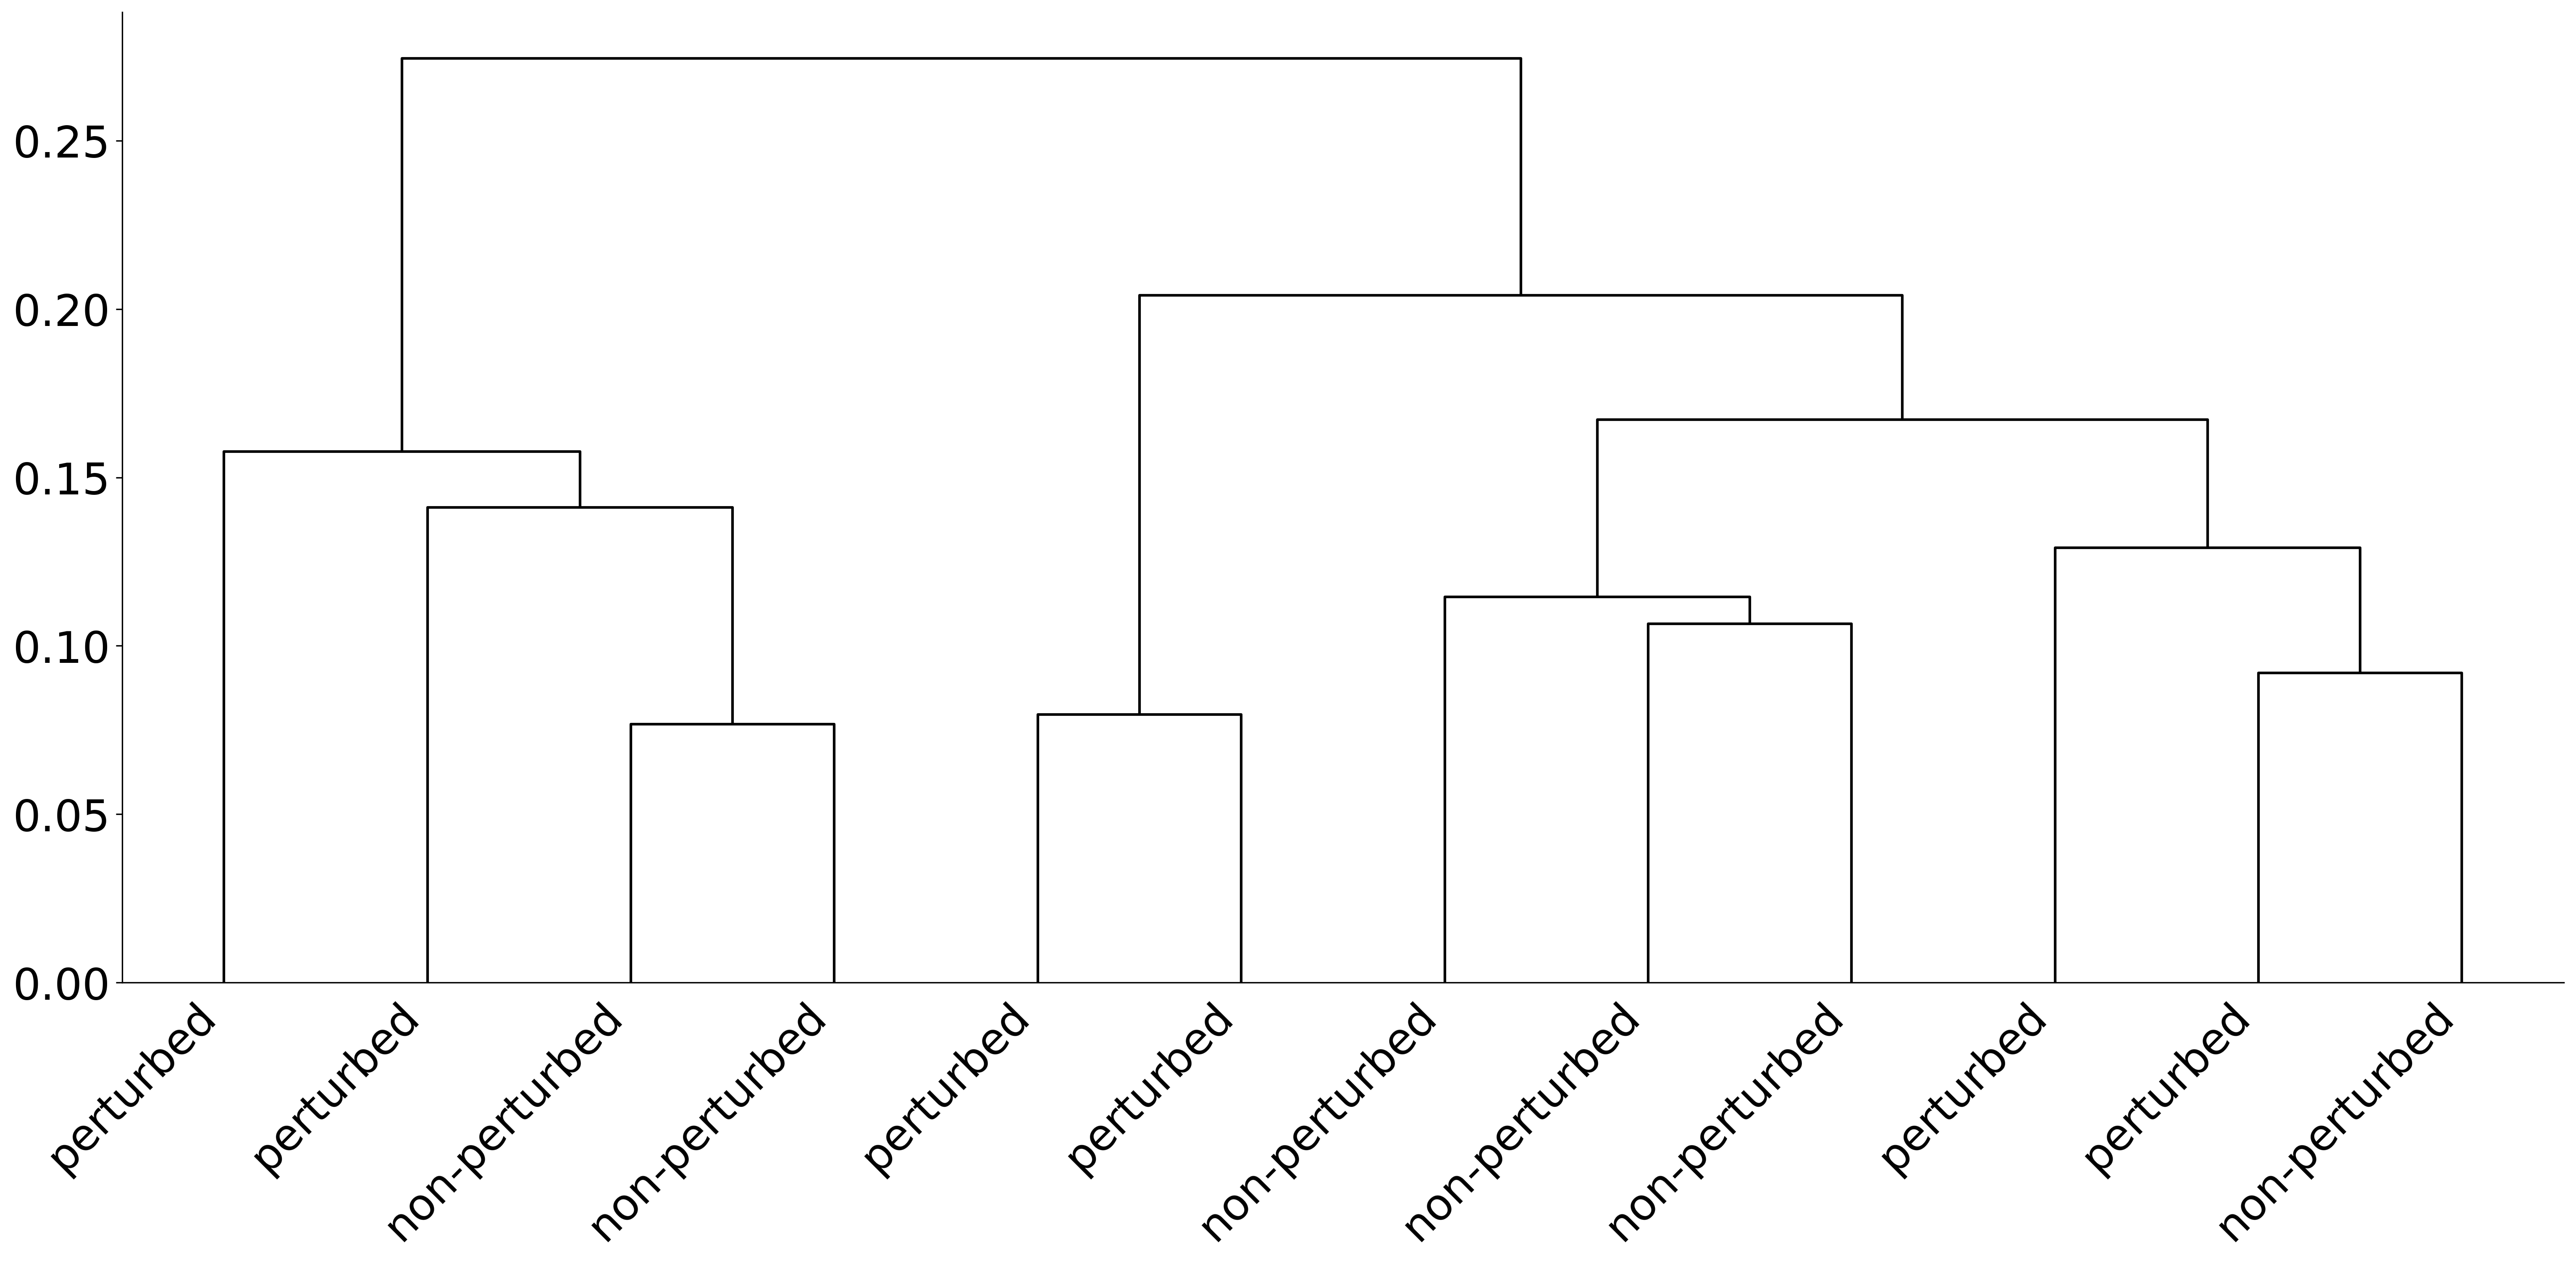

In [106]:
# plot dendrogram of average embeddings

patient_avgs = syn_data['set'].mean(dim=1).detach().numpy()

Z = linkage(patient_avgs, 'ward')

# label dendrogram by syn_data['target'] which is ordered same as emb
fig = plt.figure(figsize=(25, 10))
text_labels = list(pd.Series(syn_data['target']).map(dict(zip([0,1,2], np.unique(synthetic_adata.obs['group'], return_inverse=True)[0]))))
dn = dendrogram(Z, labels=text_labels, color_threshold=None, link_color_func=lambda k: 'black')
# 45 degree rotation x labels
plt.xticks(rotation=45, ha='right')
#larger axis labels
plt.tick_params(axis='both', which='major', labelsize=25)
plt.savefig('figures/synthetic_pheno_dendrogram_average.pdf', bbox_inches='tight')